# CV Project Code (Experiment 1)

## : Train Dataset에서 Image 추출 후 MNIST 형태로 학습하기)

Only needed for kaggle

In [1]:
!pip install keras

You should consider upgrading via the 'c:\python\python371\python.exe -m pip install --upgrade pip' command.


## Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Basic Import ##
import pandas as pd
import numpy as np
import sklearn
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Tensorflow ## 
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array # Image Related

# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Modelling
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

## Loading Data

Change the `root` to the directory of the dataset files

In [3]:
root = 'cv_test'
train = pd.read_csv(root+'/train.csv').set_index('id')
test = pd.read_csv(root+'/test.csv').set_index('id')
submission = pd.read_csv(root+'/submission.csv')

## EDA (Exploratory Data Analysis)

Training할 dataset 형식 살펴보기

In [4]:
print("데이터의 형태(행, 열):", train.shape) 
train.head()

데이터의 형태(행, 열): (2048, 786)


,digit,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,...,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,...,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,...,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,...,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,...,4,4,3,2,1,3,4,3,1,2


Training Dataset의 형태를 보면, 2048개의 Train Data가 존재하고 각 데이터는 Digit과 Letter로 이루어져 있다

0 ~ 783 의 숫자들은 28 * 28 형태의 픽셀 이미지를 나타내고 있을 것이다. 한 번 예시를 보자.

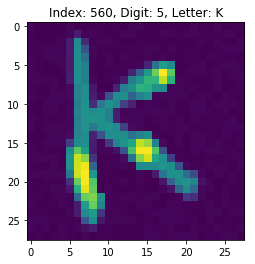

In [5]:
idx = 560
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int) # 이미지로 보모록 28*28 ndarray 꼴로 변환 
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter)) # 위의 줄 출력
plt.imshow(img)
plt.show()

다음을 보면 알파벳은 선명하게 나타나 있는데, 숫자 같은 경우는 더 진한 흔적이 존재하지만 육안으로 어떤 숫자 였는지 알아보기 힘들다.

이 데이터셋은 기존의 숫자를 적은 MNIST 데이터셋 위에 알파벳을 덮어 씌운 후, 숫자의 Trail은 지운 것으로 보인다.

이 문제에서 최종적으로 예측해야 하는 것은 글자에 가려져서 잘 안 보이는 숫자 부분이다.

이를 가장 효과적으로 인식하려면, 모델이 알파벳 모양을 인식하고 이를 제거하여 숫자를 예측한다.

## Preprocessing

In [7]:
X_train = np.array(train.drop(['digit', 'letter'], axis=1)).astype('float32') # 이미지만 학습할 수 있도록 만든다
X_test = np.array(test.drop(['letter'], axis=1)).astype('float32')

y_train = to_categorical(np.array(train['digit']), num_classes=10) # 최종적으로 나오는 것은 숫자

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=420) # 8 : 2 로 Train과 Validation을 나눔 *(seed는 고정)

X_train = X_train.reshape(-1, 28, 28, 1) # 이제 X_train 같은 경우 Train Dataset의 image로 바뀌였다.
X_val = X_val.reshape(-1, 28, 28, 1) # 이것은 validation set의 이미지
X_test = X_test.reshape(-1, 28, 28, 1) # test set은 나중에 사용할 예정

In [8]:
def test_imgs(imgs): # 이미지 10개를 보여주며 경향성을 나타낸다.
    plt.figure(figsize=(20, 5))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

TypeError: Invalid dimensions for image data

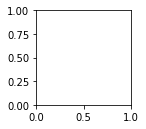

In [9]:
test_imgs(X_train)

밝은 부분만 남도록 기준 값을 설정한다

In [ ]:
X_train = X_train/255.
X_val = X_val/255.
X_test = X_test/255.

threshold = 0.6
X_train[X_train < threshold] = 0
X_val[X_val < threshold] = 0
X_test[X_test < threshold] = 0

In [ ]:
test_imgs(X_train) # 어두운 부분을 제거한 경우를 나타낸다.

이제 제거된 부분들은 숫자를 나타내는 부분들이였으므로, 이미지들을 합쳐서 원래 숫자 이미지를 구한다.

이렇게 구한 이미지는 train data를 통해 학습한 것이기 때문에 자유롭게 사용할 수 있다.

In [ ]:
digit_ref = np.zeros((10, 28, 28)) # 숫자 이미지 저장 공간
for (idx, digit) in enumerate(y_train): # 0 ~ 9 까지 분류되는 수
    digit = np.argmax(digit) # 같은 digit으로 label 된 그림
    digit_ref[digit] += X_train[idx] # 이들끼리 합성한다

In [ ]:
digit_ref = digit_ref / np.max(digit_ref)
digit_ref[digit_ref < 0.3] = 0 # 일정 빈도 안 나온 부분은 제거
digit_ref[digit_ref != 0] = 1 # 합친 모양에 대해서 나타낸다

In [ ]:
test_imgs(digit_ref)

다음 이미지들을 가지고 Test Data에 나온 이미지들이 얼마나 일치하는지 측정하는 모델을 만들어서 측정을 해보자.

In [12]:
# 불필요한 column 제거
train2 = train.drop(['digit','letter'],1)
test2 = test.drop(['letter'],1)

In [13]:
# 데이터프레임(pd)을 ndarray(np) 형식으로 변환 후 reshape
train2 = train2.values.reshape(-1,28,28,1)
test2 = test2.values.reshape(-1,28,28,1)

## Data Augmentation

In [14]:
idg = ImageDataGenerator(rotation_range=45)
idg2 = ImageDataGenerator()

train_generator = idg.flow(X_train,y_train)
valid_generator = idg2.flow(X_val,y_val)
test_generator = idg2.flow(test2,shuffle=False)

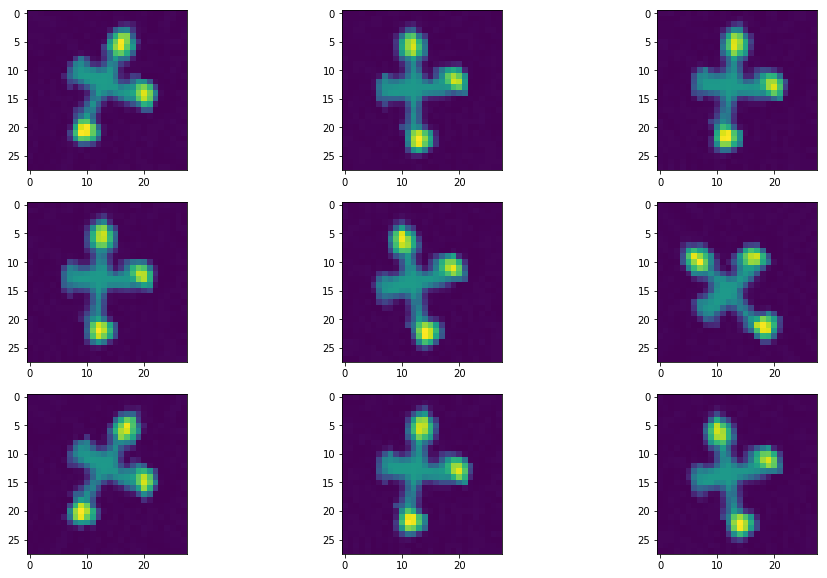

In [15]:
sample_data = train2[idx].reshape(1,28,28,1)
sample_generator = idg.flow(sample_data, batch_size=1)

plt.figure(figsize=(16,10))

for i in range(9) : 
    plt.subplot(3,3,i+1)
    plt.imshow(sample_generator[0].reshape(28,28))

## Modelling

In [20]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# reLR = ReduceLROnPlateau(patience=20,verbose=1,factor=0.5) #learning rate scheduler
# es = EarlyStopping(patience=30, verbose=1)
# mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1)

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-23-d9f7d81b1ed2>:1) ]] [Op:__inference_train_function_1083]

Function call stack:
train_function


In [ ]:
history.history.keys()

### Visualize Training Process

In [ ]:
learning_history = model.fit(train_generator, validation_data=valid_generator, epochs=100, callbacks=[es,mc,reLR])

In [ ]:
# save val_loss
hist = pd.DataFrame(learning_history.history)
hist['val_loss'].min()

In [ ]:
hist.columns

plt.title('Training and validation loss')
plt.xlabel('epochs')

plt.plot(hist['val_loss'])
plt.plot(hist['loss'])
plt.legend(['val_loss','loss'])

plt.figure()

plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.legend(['acc','val_acc'])
plt.title('Training and validation accuracy')


plt.show()

## Final Prediction

최종 예측은 Train dataset으로 만든 모델이 Test Dataset에 있는 random한 경우에 관해 얼마만큼 정확한 예측률을 출력할 수 있는 지로 나타낼 수 있다.

기존 Dacon에서는 submission 파일을 제출하는 것으로 끝나지만, 우리는 성능을 테스트하기 위해 예측한 파일이 어느 정도의 정확도를 보이는지를 나타낼 것이다.

Private dataset으로 평가를 받을 수 없으므로 train dataset과 비교하여 최종적으로 가장 높은 정확도를 출력할 수 있는 모델을 목표로 한다.

In [ ]:
result = model.predict(test_generator, verbose=True)

In [ ]:
submission['digit'] = result.argmax(1)
# submission['digit'] = np.argmax(model.predict(x_test), axis=1) 
# 각 digit에 만든 모델을 적용시켜 값 중 가장 큰 값의 index를 출력 (그게 곧 숫자)
submission.head() # 앞의 값 5개 출력

In [ ]:
correct_prediction = tf.equal(submission['digit'], test['digit'])
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('최종 ACCURACY : ', accuracy)